# SLT-CE-1: Locally Linear Embedding

<h2 style="background-color:#f0b375;"> Setup </h2>

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn as skl
import numpy as np

from tensorflow.examples.tutorials.mnist import input_data
from sklearn.utils.validation import check_is_fitted

from sklearn.manifold import LocallyLinearEmbedding as SklearnLLE

In [2]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=False)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


<p style="background-color:#adebad;">
The MNIST data set contains three sets: **mnist.train, mnist.validation, mnist.test**  
Each of them is a numpy array with samples along rows, and pixels along columns.   
The original shape of the images is 28x28 = 784.
</p>

In [3]:
mnist.train.images.shape

(55000, 784)

In [4]:
mnist.validation.images.shape

(5000, 784)

In [5]:
mnist.test.images.shape

(10000, 784)

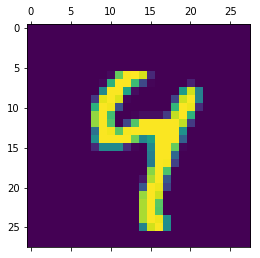

In [6]:
plt.matshow(mnist.train.images[2].reshape(28,28))
plt.show()

<h2 style="background-color:#f0b375;">
Section 4.0 
<span style=font-size:50%> Complete all problems in this section to get a pass on this exercise. </span>
</h2>

<p style="background-color:#adebad;">
    Shortly recapitulate the Locally Linear Embedding (LLE) algorithm, and the involved formulas.
</p>

Put your markdown text here (it can also do Latex, just put it between two dollar signs! $\sum$)

<p style="background-color:#adebad;">
    Implement the <b>fit method</b> for the template class LocallyLinearEmbedding, according to the contract outlined in its docstring.<br>
    In particular, use the class attribute (variable) names as provided, and introduce new class attributes only if necessary.
</p>

In [7]:
import scipy as sp # use scipy for sparse matrix and faster eigen-solver

class LocallyLinearEmbedding(skl.base.BaseEstimator, skl.base.TransformerMixin):
    """Template class for LLE, compare to `sklearn LLE`_.
    
    Attributes:
        embedding_vectors_ (np.ndarray): Embedding of input X with shape (samples, n_components)
        nbrs_X (e.g. sklearn.neighbors.KDTree): NearestNeighbors (NN) object, stores NN for training set X.
        nbrs_y (e.g. sklearn.neighbors.KDTree): NearestNeighbors (NN) object, stores NN for embedding_vectors_.
        M_ (np.array): Symmetric matrix (samples, samples), used in quadratic form for embedding.
        X_ (np.array): Copy of training set with shape (samples, dim).
    
       .. _`sklearn LLE`: http://scikit-learn.org/stable/modules/generated/sklearn.manifold.LocallyLinearEmbedding.html
    """
    
    def __init__(self, n_components=2, n_neighbors=5):
        self.n_neighbors = n_neighbors
        self.n_components = n_components
    
    def fit(self, X):
        """Compute LLE embedding of vectors X
        
        First, compute nbrs_X and M_.
        Finally, compute embedding_vectors_.
        
        Args:
            X (np.ndarray): Input array with shape (samples, dim)
        
        Returns:
            self
        """
        self.X_ = np.copy(X)
        self.nbrs_X = skl.neighbors.KDTree(X)
        n_samples = X.shape[0]
        
        # get nearest neighbors indices
        # get +1 and skip first to account for self
        ind = self.nbrs_X.query(X, k=self.n_neighbors+1, return_distance=False)[:, 1:]

        # calculate barycenter weights w
        w = np.empty((n_samples, self.n_neighbors)) # placeholder for weights
        C = np.empty((self.n_neighbors, self.n_neighbors)) # placeholder for covariances
        for i in range(n_samples):
            # populate covariance matrix C
            for j in range(self.n_neighbors):
                for k in range(self.n_neighbors):
                    eta_j = self.X_[ind[i, j]]
                    eta_k = self.X_[ind[i, k]]
                    C[j, k] = np.dot((X[i] - eta_j), (X[i] - eta_k))
            # calculate the weights
            w[i] = np.linalg.solve(C, np.ones((self.n_neighbors)))
            w[i] = w[i] / np.sum(w[i]) # normalize

        # create sparse barycenter graph from weights
        W = sp.sparse.lil_matrix((n_samples, n_samples))
        for i in range(n_samples):
            W[i, ind[i]] = w[i]

        M = sp.sparse.eye(*W.shape) - W
        M = (M.T * M).tocsc()
        self.M_ = M

        random_state = np.random.RandomState(42) # make it reproducible and use same seed as skl example
        v0 = random_state.uniform(-1, 1, M.shape[0])
        evals, evecs = sp.sparse.linalg.eigsh(M, k=self.n_components+1, sigma=0.0, v0=v0)
        self.embedding_vectors_ = evecs[:, 1:]
    
    def transform(self, X):
        """Map new vectors X to embedding space
        
        Use the fitted model to map new vectors to the space with dimension n_components.
        
        Args:
            X (np.ndarray): Input array with shape (new_samples, dim)
            
        Returns:
            y (np.ndarray): Embedded vectors with shape (new_samples, n_components)
        """
        check_is_fitted(self, ["embedding_vectors_", "nbrs_X"])
        
        n_samples = X.shape[0]
        
        # get nearest neighbors indices
        # do not skip first element here (first!=self)
        ind = self.nbrs_X.query(X, k=self.n_neighbors, return_distance=False)

        # calculate barycenter weights w
        w = np.empty((n_samples, self.n_neighbors)) # placeholder for weights
        C = np.empty((self.n_neighbors, self.n_neighbors)) # placeholder for covariances
        for i in range(n_samples):
            # populate covariance matrix C
            for j in range(self.n_neighbors):
                for k in range(self.n_neighbors):
                    eta_j = self.X_[ind[i, j]]
                    eta_k = self.X_[ind[i, k]]
                    C[j, k] = np.dot((X[i] - eta_j), (X[i] - eta_k))
            # calculate the weights
            w[i] = np.linalg.solve(C, np.ones((self.n_neighbors)))
            w[i] = w[i] / np.sum(w[i]) # normalize

        # project into embedding space
        y = np.empty((n_samples, self.n_components))
        for i in range(n_samples):
            y[i] = np.dot(self.embedding_vectors_[ind[i]].T, w[i])
        return y

    def inverse_transform(self, y):
        """Map new vectors y to input space with dimension dim.
        
        Use the fitted model to map vectors y to the original input space.
        
        Args:
            y (np.ndarray): Input array with shape (new_samples, n_components)
            
        Returns:
            X (np.ndarray): Vectors with shape (new_samples, dim)
        """
        check_is_fitted(self, ["embedding_vectors_", "X_", "nbrs_y"])
        raise NotImplementedError()

<p style="background-color:#adebad;">
    Create an instance of your LLE class with default parameters and fit the MNIST validation set. Record the execution time (should be about 30 sec). Furthermore, create an instance of the sklearn LLE class, and fit it with the same parameters. Again record the execution time.  
    Note, the dots should be filled in by you.
</p>

In [8]:
%%time
myLLE = LocallyLinearEmbedding()
myLLE.fit(mnist.validation.images)

CPU times: user 42.4 s, sys: 229 ms, total: 42.6 s
Wall time: 40.2 s


In [9]:
%%time
sklLLE = SklearnLLE(random_state=42)
sklLLE.fit(mnist.validation.images)

CPU times: user 47.8 s, sys: 280 ms, total: 48.1 s
Wall time: 45.6 s


<p style="background-color:#adebad;">
    Plot myLLE.embedding\_vectors\_ and sklLLE.embedding\_vectors\_ in two separate plots.
</p>

In [10]:
def plt_mnist(embedding, of="validation"):
    labels = getattr(mnist, of).labels
    
    if len(labels) != len(embedding):
        raise ValueError("Number of labels does not match number of embeddings")
    
    for label in range(10):
        idx = (labels == label)
        plt.scatter(embedding[idx, 0], embedding[idx, 1], alpha=0.5, label=str(label))
    plt.legend()

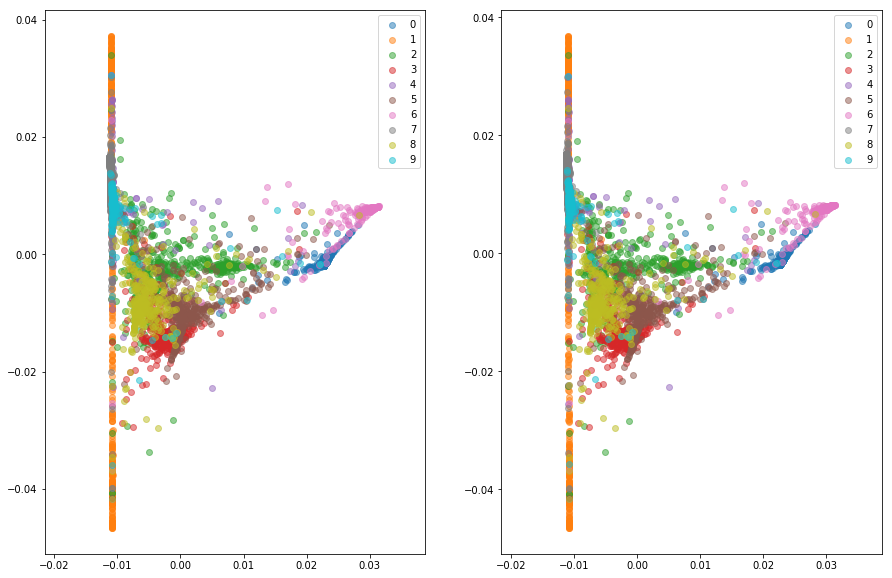

In [11]:
plt.figure(figsize=(15,10))
plt.subplot(121)
plt_mnist(sklLLE.embedding_)
plt.subplot(122)
plt_mnist(myLLE.embedding_vectors_) # <--- uncomment this!

<h2 style="background-color:#f0b375;"> Section 4.5
<span style=font-size:50%> Complete all problems in this and previous sections to get a 4.5 on this exercise. </span>
</h2>

<p style="background-color:#adebad;">
    <ul style="background-color:#adebad;">
        <li> Implement the <b>transform method</b> for the template class LocallyLinearEmbedding, according to the contract outlined in its docstring.
        </li>
        
        <li>Fit both, myLLE and sklLLE on the MNIST validation set, and use the fitted model to transform the MNIST test set.
        </li>
        
        <li>
            Plot both embeddings in two separate plots for comparison.
        </li>
    </ul>
</p>

In [12]:
%%time
my_embedding = myLLE.transform(mnist.test.images)

CPU times: user 1min 11s, sys: 261 ms, total: 1min 12s
Wall time: 1min 12s


In [13]:
%%time
skl_embedding = sklLLE.transform(mnist.test.images)

CPU times: user 1min 25s, sys: 456 ms, total: 1min 26s
Wall time: 1min 25s


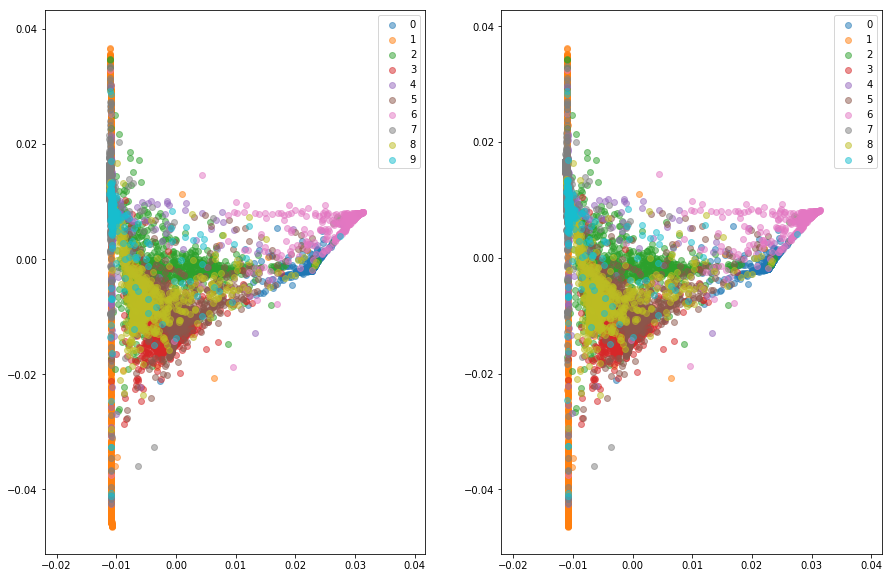

In [14]:
# Put the plots here
plt.figure(figsize=(15,10))
plt.subplot(121)
plt_mnist(skl_embedding, of='test')
plt.subplot(122)
plt_mnist(my_embedding, of='test')

<h2 style="background-color:#f0b375;"> Section 5.0
<span style=font-size:50%> Complete all problems in this and previous sections to get a 5.0 on this exercise. </span>
</h2>

<ul style="background-color:#adebad;">
    <li> Think how you can invert the LLE embedding, and shortly describe your approach.</li>
        <li> Using your approach, implement the <b>inverse_transform method</b> for the template class LocallyLinearEmbedding, according to the contract outlined in its docstring.
        </li>
        <li>
        Use myLLE.transform and myLLE.inverse_transform to embed the first digit of the MNIST training set and then recover it. 
        </li>
       
    </ul>

Put the description of your approach to invert the LLE embedding here.

In [ ]:
embedded_digit = myLLE.transform(mnist.train.images[0])
reconstructed_digit = myLLE.inverse_transform(embedded_digit)

<ul style="background-color:#adebad;">
        <li>
        Plot the original digit and the reconstructed digit for comparison.
        </li>
    </ul>

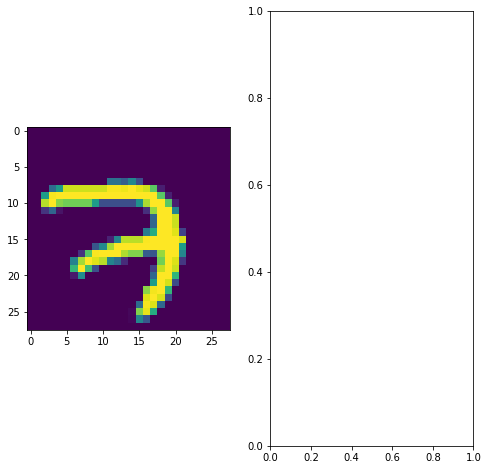

In [54]:
plt.figure(figsize=(8,8))
plt.subplot(121)
plt.imshow(mnist.train.images[0].reshape(28,28))
plt.subplot(122)
# plt.imshow(reconstructed_digit.reshape(28,28))

<h2 style="background-color:#f0b375;"> Section 5.5
<span style=font-size:50%> Complete all problems in this and previous sections to get a 5.5 on this exercise. </span>
</h2>

<ul style="background-color:#adebad;">
        <li>
        Perform a grid search of the reconstruction error, i.e. the trace of the matrix M_, over the parameters n_neighbors, and n_components.  
        Create a nice 2D heatmap of the results.
        </li>
    </ul>

In [ ]:
# todo: vary n_neighbors and n_components and plot heatmap of reconstruction error (i.e. x,y direction are params)
# and color/shade is reconstruction error

<ul style="background-color:#adebad;">
        <li>
        Create a matrix plot of the matrix M\_.  
        Make sure to permute the rows and columns according to the digit labels, so that you can actually observe the block structure. Also make sure to scale the plot properly, so that you can observe the block structure. What is the origin of the block structure?
        </li>
        <li>
        Plot the spectrum (eigenvalues) of M\_. Can you identify a good cutoff? What could you use the value of the cutoff for?
        </li>
    </ul>

<h2 style="background-color:#f0b375;"> Section 6.0
<span style=font-size:50%> Complete all problems in this and previous sections to get a 6.0 on this exercise. </span>
</h2>

<ul style="background-color:#adebad;">
        <li>
        Plot the linear interpolation between two digits $x_1,\ x_2$ in the input space compared to the reconstruction along the linear interpolation of their embeddings $y_1, y_2$. More precisely, compare $\lambda x_1 + (1-\lambda) x_2,\ \lambda\in[0,1]$ to $LLE^{-1}\big(\lambda y_1 + (1-\lambda) y_2\big),\ \lambda\in[0,1]$
        </li>
    </ul>

<ul style="background-color:#adebad;">
        <li>
        Select images of digits "6" and a digits "8".  
        Rotate the input images by 360° in steps of 1° and create the embedding of each rotation.  
        Create a nice plot of the respective trajectories in the 2D embedding space (Make sure to use markers for the embeddings, and connect them with a line. Use labels and legends, and add some embeddings of other digits to put the trajectories into context).
        </li>
    </ul>